This script produces figures and analyses for the pretone (stimulus-based) condition in the section "Rule- and stimulus-based biases exhibited distinct physiological signatures".

Relies on regressions produced by pretoneOnly_pupil_lme5_FINAL.R, pretoneOnly_pupil_lme_stim3_FINAL.R.

Produces all subplots of Figure 6.

## Data setup/loading

In [1]:
imatlab_export_fig('print-svg')
set(0,'defaultfigurecolor',[1 1 1])
set(groot,'DefaultAxesFontName','Arial')

%set paths (might want to change where this ultimately goes)
addpath('../');

DS = 500;
rmNaN = true;

%set directories/files
TASK_DATA_DIR = '..\data';
SAVE_DIR = 'C:\Users\ntard\OneDrive\Goldlab\AuditoryPriors\cached data';

DATA_VALID = 'valid_pupil_pretoneOnly_07-Apr-2021.mat';
DATA_BL = 'pupil_data_bl_pretoneOnly_07-Apr-2021.mat';
if DS==500
    DATA_FILE = 'pupil_data_ds500_pretoneOnly_26-Apr-2021.mat';
    DATA_META = 'pupil_metadata_ds500_pretoneOnly_26-Apr-2021.mat';
elseif DS==50
    DATA_FILE = 'pupil_data_ds50_pretoneOnly_26-Apr-2021.mat';
    DATA_META = 'pupil_metadata_ds50_pretoneOnly_26-Apr-2021.mat';
elseif isempty(DS)
    DATA_FILE = 'pupil_data_pretoneOnly_07-Apr-2021.mat';
    DATA_META = 'pupil_metadata_pretoneOnly_07-Apr-2021.mat';
end

TASK_DATA_FILE = 'priorOnly_pretoneOnly_pretone_pL_pretone_pH_pretone5_05-Feb-2021.csv';

% read in task data 
task_data = read_data_csv(fullfile(TASK_DATA_DIR,TASK_DATA_FILE)); %read_task_data(DATA_DIR,'pretoneOnly');
task_data(~strcmp(task_data.optionName,'pretoneOnly'),:) = [];

In [2]:
%set up task variables for joining w/ pupil
task_data.aSNR = abs(task_data.SNR);

%congruent relative to stim
task_data.congruentS = nan(height(task_data),1);
task_data.congruentS((task_data.ptC=='HH' & task_data.isH==1) | ...
    (task_data.ptC=='LL' & task_data.isH==0)) = 3;
task_data.congruentS((task_data.ptC=='HL' & task_data.isH==1) | ...
    (task_data.ptC=='LH' & task_data.isH==0)) = 2;
task_data.congruentS((task_data.ptC=='LH' & task_data.isH==1) | ...
    (task_data.ptC=='HL' & task_data.isH==0)) = 1;
task_data.congruentS((task_data.ptC=='LL' & task_data.isH==1) | ...
    (task_data.ptC=='HH' & task_data.isH==0)) = 0;

%congruent relative to choice
task_data.congruent = nan(height(task_data),1);
task_data.congruent((task_data.ptC=='HH' & task_data.choice01==1) | ...
    (task_data.ptC=='LL' & task_data.choice01==0)) = 3;
task_data.congruent((task_data.ptC=='HL' & task_data.choice01==1) | ...
    (task_data.ptC=='LH' & task_data.choice01==0)) = 2;
task_data.congruent((task_data.ptC=='LH' & task_data.choice01==1) | ...
    (task_data.ptC=='HL' & task_data.choice01==0)) = 1;
task_data.congruent((task_data.ptC=='LL' & task_data.choice01==1) | ...
    (task_data.ptC=='HH' & task_data.choice01==0)) = 0;
    
task_join_vars = {'aSNR','isH','success','choice01','pretoneLength','pretoneBias',...
        'ptC','congruentS','congruent'};

In [3]:
%load in/clean all data
[~,data,metadata,baselines,task_data,ID2subj,validTrials,validTrialsBL] = ...
    load_pd_data(...
        fullfile(SAVE_DIR,DATA_FILE),...
        fullfile(SAVE_DIR,DATA_META),...
        fullfile(SAVE_DIR,DATA_BL),...
        DATA_VALID,...
        task_data,...
        task_join_vars);
        
% create new stimOn variable for onset of TEST tone
data.trial_time_stimOnT = data.trial_time_stimOff + 300;

### Trial accounting/removal of subjects w/o enough data after cleaning
Now that we've merged everything we need to redo the trial accounting we did at end of QA to account for additional missingness, etc.

median trials/subject: 299 | min: 10 | max 430

median baseline trials/subject: 386 | min: 167 | max 437

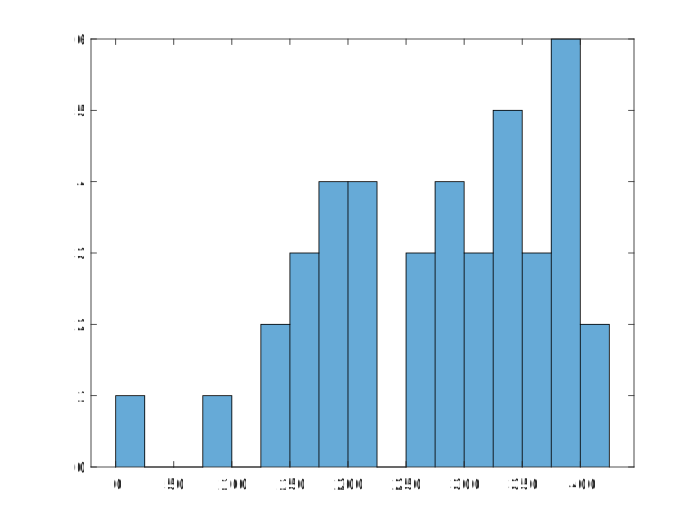

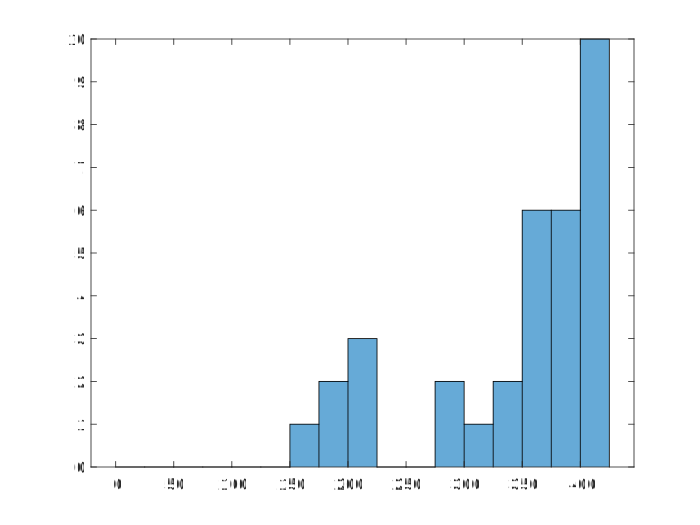

In [4]:
%how many trials left/subject for pupil data?
trialList = unique(data(:,{'dataID','trialN'}),'rows');
vt_sum = varfun(@length,trialList,'InputVariables','trialN','GroupingVariables','dataID');
figure();histogram(vt_sum.length_trialN,[0:25:max(vt_sum.length_trialN)])
fprintf('median trials/subject: %d | min: %d | max %d\n\n',median(vt_sum.length_trialN),...
    min(vt_sum.length_trialN), max(vt_sum.length_trialN))

%how many trials left/subject for baseline pupil data?
trialListBL = unique(baselines(:,{'dataID','trialN'}),'rows');
vt_sumBL = varfun(@length,trialListBL,'InputVariables','trialN','GroupingVariables','dataID');
figure();histogram(vt_sumBL.length_trialN,[0:25:max(vt_sumBL.length_trialN)])
fprintf('median baseline trials/subject: %d | min: %d | max %d',median(vt_sumBL.length_trialN),...
    min(vt_sumBL.length_trialN), max(vt_sumBL.length_trialN))

In [5]:
% remove subjects with not enough trials from analysis
% (should maybe eventually merge this in w/ validTrials/do in QA step)

trial_paucity_subj = vt_sum.dataID(vt_sum.length_trialN < 75);

data = data(~ismember(data.dataID,trial_paucity_subj),:);

fprintf('pretoneOnly N: %d',length(unique(data.dataID)))

pretoneOnly N: 42

#### output for R

In [6]:
%% output for R
if false
    if DS~=50
        error('You only want to output 50 Hz fool!')
    end
    writetable(data(:,{'trialN','trial_time_choice','trial_time_stimOn','trial_time_stimOff',...
        'pupilCblz','posXCbl','posYCbl','dataID','pupilCblz2','aSNR','isH','success','choice01',...
        'pretoneLength','congruentS','congruent'}),...
        fullfile(SAVE_DIR,sprintf('pupil_data_pretoneOnly_ds%d_forR_%s.csv',DS,date())));
    writetable(baselines,fullfile(SAVE_DIR,sprintf('pupil_data_pretoneOnly_bl_forR_%s.csv',date())));
    writetable(ID2subj,fullfile(SAVE_DIR,sprintf('pupil_data_pretoneOnly_ds%d_id2subj_forR_%s.csv',DS,date())))
end

## choice-aligned

### Congruence x SNR
Just plotting most extreme conds.

In [7]:
data_ave_choice_SNR_congruent2_subj = varfun(@nanmean,...
    data(data.trial_time_choice >= -1050 & data.trial_time_choice <= 1000,:),...
    'InputVariables','pupilCblz2',...
    'GroupingVariables',{'dataID','success','aSNR','congruent','trial_time_choice'});
data_ave_choice_SNR_congruent2 = summary_stats(data_ave_choice_SNR_congruent2_subj,...
    'nanmean_pupilCblz2',...
    {'success','aSNR','congruent','trial_time_choice'},1);

congruent=3 | SNR=0.05
congruent=0 | SNR=0.05
congruent=3 | SNR=0.50
congruent=0 | SNR=0.50
congruent=3 | SNR=0.05
congruent=0 | SNR=0.05
congruent=3 | SNR=0.50
congruent=0 | SNR=0.50


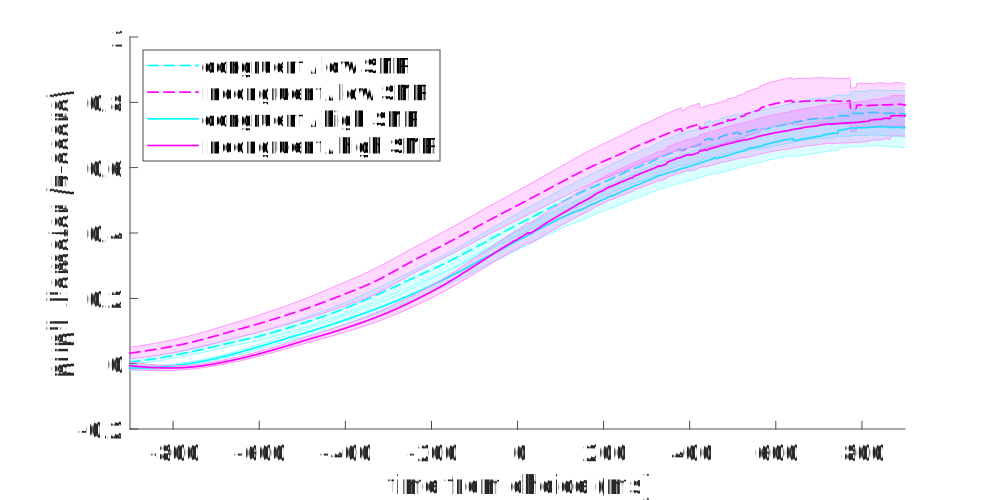

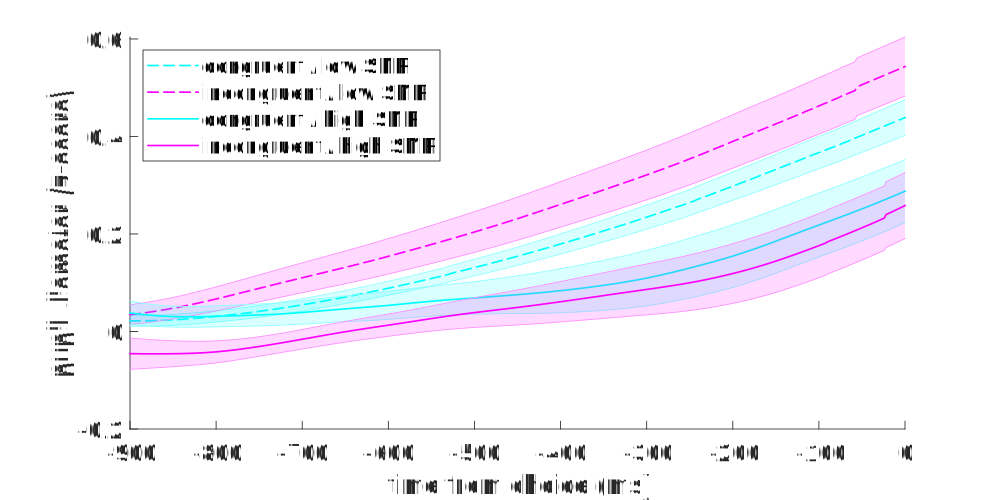

In [8]:
%Fig 6a

set(groot,'DefaultAxesFontSize',15)

%line_specs = {'c','m';'--c','--m'};
line_specs = {'--c','--m';'c','m'};
%aSNRs = [.5,.05];
aSNRs = [.05,.5];
conds = [3,0];
%cond_labels = {'congruent / high SNR','incongruent / high SNR',...
%    'congruent / low SNR','incongruent / low SNR'};
cond_labels = {'congruent / low SNR','incongruent / low SNR',...
    'congruent / high SNR','incongruent / high SNR'};
success = [1,0];
success_title = {'correct','incorrect'};
t_lim = [-900 900];

for c=1:length(success)
    figure('Position',[0 0 800 400]);hold on;
    hC = [];
    for s=1:length(aSNRs)
        for j=1:length(conds)
            fprintf('congruent=%d | SNR=%.2f\n',conds(j),aSNRs(s));
            this_data_con_SNR = data_ave_choice_SNR_congruent2(...
                data_ave_choice_SNR_congruent2.congruent == conds(j) & ...
                data_ave_choice_SNR_congruent2.success == success(c) & ...
                data_ave_choice_SNR_congruent2.aSNR == aSNRs(s),:);
            h=shadedErrorBar(this_data_con_SNR.trial_time_choice, ...
                this_data_con_SNR.nanmean_nanmean_pupilCblz2, ...
                this_data_con_SNR.nansem_nanmean_pupilCblz2, ...
                line_specs{s,j},1);
            hC = [hC h.mainLine];
        end
    end
    %title(['Choice congruent pt x SNR - ' success_title(c)])
    xlabel('time from choice (ms)')
    ylabel('pupil diameter (z-score)')
    if true %success(c)==1
        legend(hC,cond_labels, 'Location', 'northwest')
    end
    if success(c)==1
        xlim(t_lim);
    else
        xlim([-900 0]);
    end
    [hC.LineWidth] = deal(1); 
    
    set(gcf,'Renderer','painters')
end

set(groot,'DefaultAxesFontSize','factory')

### choice regression

Pupil data were downsampled to 50 Hz. A linear mixed-effects model was then run at every time point between -1000 ms and -40 ms (correct trials only for now, last time point chosen to correspond to first significant time point of the incongruent - congruent contrast in the precue regression) relative to choice of the form:


$$ pupil_t = \beta_{0_t} + \beta_{congruent_t} + \beta_{|SNR|_t} + \beta_{congruent:|SNR|_t} + \beta_{isH_t}  + \beta_{bl_t} + \beta_{posX_t} + \beta_{posY_t} + \beta_{pretoneLength_t}$$

Only the most extreme congruency (both tones (in)congruent) and SNR (0.05,0.20) conditions were fit, and so unlike the main precue model SNR was modeled as a dichotomous not continous variable. The model at each time point was initial fit with the maximal random effects structured. In cases of convergence/boundary issues, the complexity of the random effects structure was iteratively reduced following the recommendations of Bates et al., 2015. All categorical variables (congruent, |SNR|, isH) were effect coded. Continuous variables were z-scored across subjects, except for baseline pupil; because it was already z-scored within-subject, it was only mean-centered across subjects.


p_var =

    'p_corr'

Set 'VariableNamingRule' to 'preserve' to use the original column headers as table variable names.
Set 'VariableNamingRule' to 'preserve' to use the original column headers as table variable names.
Set 'VariableNamingRule' to 'preserve' to use the original column headers as table variable names.
Set 'VariableNamingRule' to 'preserve' to use the original column headers as table variable names.


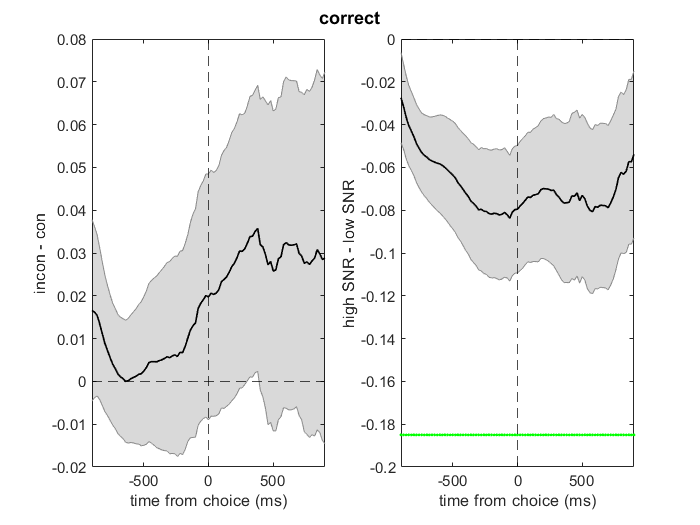

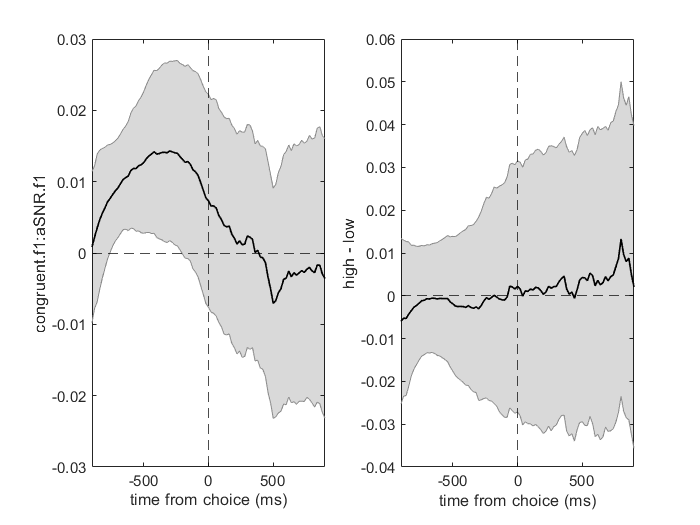

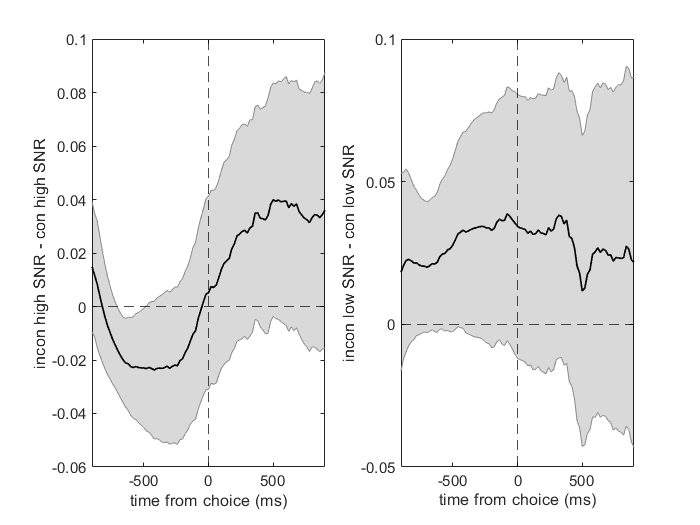

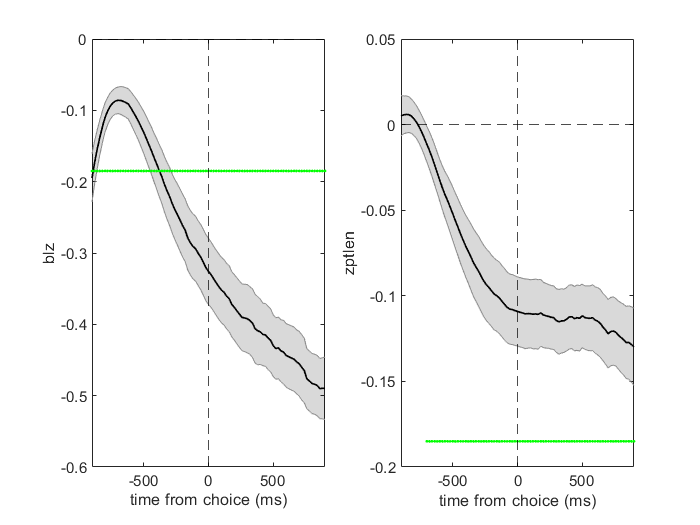

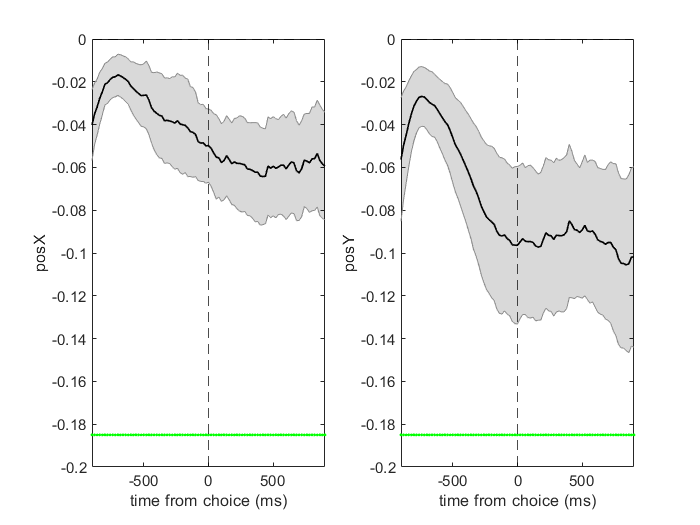

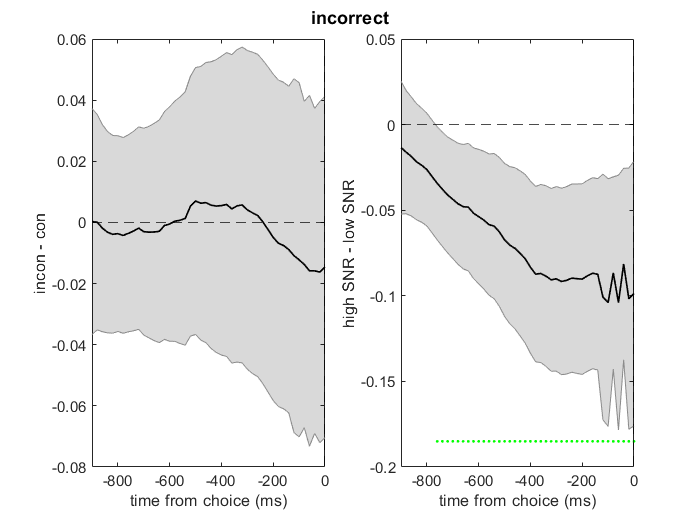

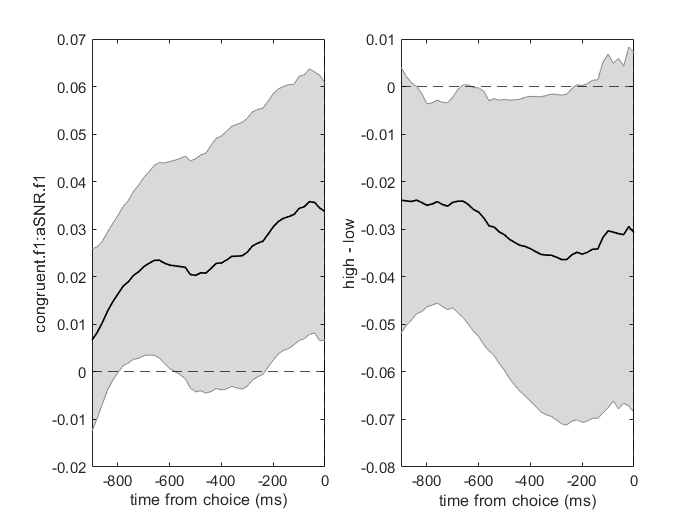

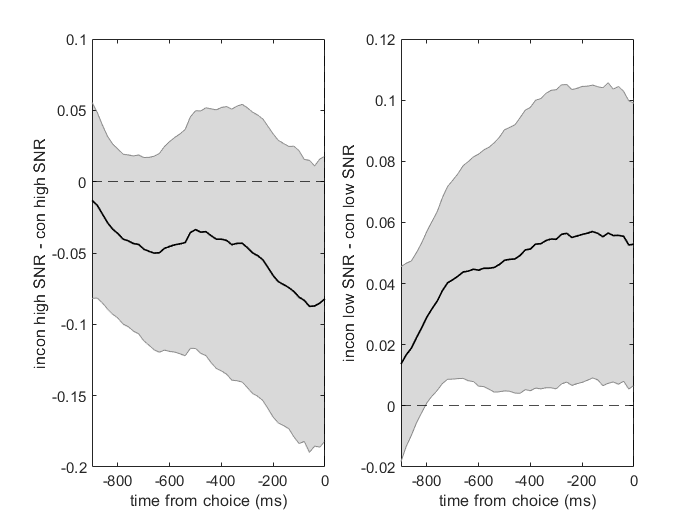

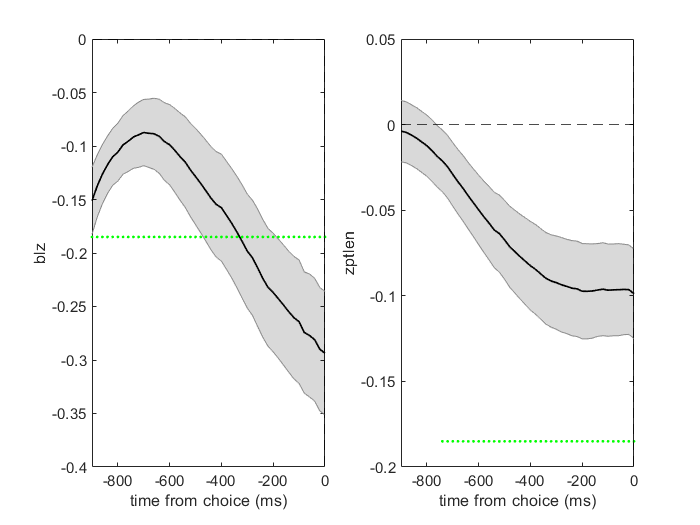

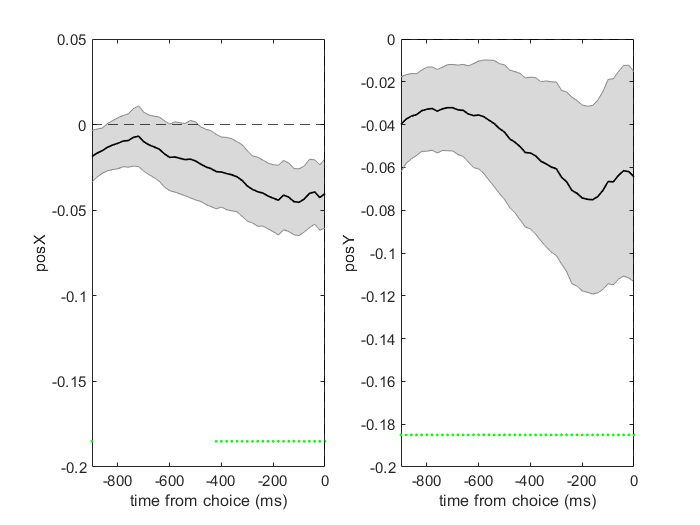

In [9]:
%these will probably be combined in R eventually(?)
p_type = 2;
p_list = {'p','p_corr'};
p_colors = {[0.5 0.8 0.5],'green'};
p_var = p_list{p_type}

CHOICE_LM_FILE = {'choice_ptO_lm_cs_final_2021-06-09.csv',...
    'choice_ptO_lm_is_final_2021-06-10.csv'};
CHOICE_EMM_FILE = {'choice_ptO_emm_cs_final_2021-06-09.csv',...
    'choice_ptO_emm_is_final_2021-06-10.csv'};

choice_lm = [];
choice_emm = [];
choice_lm_success = [1 0];
for i=1:length(choice_lm_success)
    this_choice_lm = readtable(CHOICE_LM_FILE{i});
    this_choice_lm.success = repmat(choice_lm_success(i),...
        height(this_choice_lm),1);
    choice_lm = [choice_lm; this_choice_lm];
    
    this_choice_emm = readtable(CHOICE_EMM_FILE{i});
    this_choice_emm.success = repmat(choice_lm_success(i),...
        height(this_choice_emm),1);
    choice_emm = [choice_emm; this_choice_emm];
    
    clear this_choice_lm this_choice_emm
end
choice_lm = [choice_lm;choice_emm];
clear choice_emm;

choice_lm = sortrows(choice_lm,{'success','time','param'}); % {'time','param'});
choice_lm.CI_halfwidth = choice_lm.B - choice_lm.CI_lower;

%restrict to timepoints we are going to actually include in analysis before fdr correct
t_lim = [-900 900];
choice_lm(choice_lm.time<t_lim(1) | choice_lm.time>t_lim(2),:) = [];

%now FDR correct! [NOT IMPLEMENTED IN R as of now]
group_correct = {'incon high SNR - con high SNR','incon low SNR - con low SNR'};
choice_lm = lm_adjust(choice_lm,group_correct);

plot_params = {{'incon - con', 'high SNR - low SNR'},... 
                {'congruent.f1:aSNR.f1','high - low'},...
                {'incon high SNR - con high SNR','incon low SNR - con low SNR'},...
                {'blz','zptlen'},{'posX','posY'}};
ylim_min = -.2; %[-.275,-.63];
success_title = {'correct','incorrect'};
for s=1:length(choice_lm_success)
    for pp=1:length(plot_params)
        this_plot_params = plot_params{pp};
        figure();
        for i=1:length(this_plot_params)
            subplot(1,2,i)
            this_param = this_plot_params{i};
            this_choice_lm = choice_lm(strcmp(choice_lm.param,this_param) & choice_lm.success==choice_lm_success(s),:);
            h_choice_lm=shadedErrorBar(this_choice_lm.time, ...
                this_choice_lm.B, ...
                this_choice_lm.CI_halfwidth, ...
                '-k',1);
            xlabel('time from choice (ms)')
            ylabel(this_param)
            h_choice_lm.mainLine.LineWidth = 1;
            hold on;

            %add significance line
            choice_sig = double(this_choice_lm.(p_var) < 0.05);
            choice_sig(choice_sig == 0) = NaN;
            choice_sig_y = ylim_min + (.1 - ylim_min)*.05;%min(choice_lm.CI_lower(strcmp(choice_lm.param,this_param))) - .05;
            h_choice_sig = plot(this_choice_lm.time,...
                choice_sig .* choice_sig_y,'.','LineWidth',1, 'Color', p_colors{p_type},...
                'MarkerSize',5);
            yline(0,'--k');
            xline(0,'--k');
            %ylim([ylim_min(pp) 1]);
            xlim([min(choice_lm.time(choice_lm.success==choice_lm_success(s))) ...
                max(choice_lm.time(choice_lm.success==choice_lm_success(s)))]);

            clear this_choice_lm
        end
        %suplabel(sprintf('success=%d',choice_lm_success(s)),'t',...
        %    [.08 .1 .84 .84]);
        if pp==1
            suplabel(success_title{s},'t',...
                [.08 .1 .84 .84]);
        end
    end
end

In [10]:
%FINAL

%what is last/first sig time point for interaction?
disp('correct')
int_choice_lm=choice_lm(strcmp(choice_lm.param,'congruent.f1:aSNR.f1') & ...
    choice_lm.success==1,:);
min(int_choice_lm.time(int_choice_lm.p_corr<.05))
max(int_choice_lm.time(int_choice_lm.p_corr<.05))

min(int_choice_lm.time(int_choice_lm.p<.05))
max(int_choice_lm.time(int_choice_lm.p<.05))

disp('incorrect')
int_choice_lmi=choice_lm(strcmp(choice_lm.param,'congruent.f1:aSNR.f1') & ...
    choice_lm.success==0,:);

min(int_choice_lmi.time(int_choice_lmi.p_corr<.05))
max(int_choice_lmi.time(int_choice_lmi.p_corr<.05))

min(int_choice_lmi.time(int_choice_lmi.p<.05))
max(int_choice_lmi.time(int_choice_lmi.p<.05))

%any of the pairwise sig uncorrected?
choice_lm(ismember(choice_lm.param,{'incon low SNR - con low SNR',...
    'incon low SNR - con low SNR'}) & choice_lm.p<.05 & choice_lm.success==1,...
    {'param','time','p','p_corr'})

correct

ans =

  0x1 empty double column vector


ans =

  0x1 empty double column vector


ans =

  -740


ans =

  -220

incorrect

ans =

  0x1 empty double column vector


ans =

  0x1 empty double column vector


ans =

  -780


ans =

     0


ans =

  0x4 empty table




p_var =

    'p'



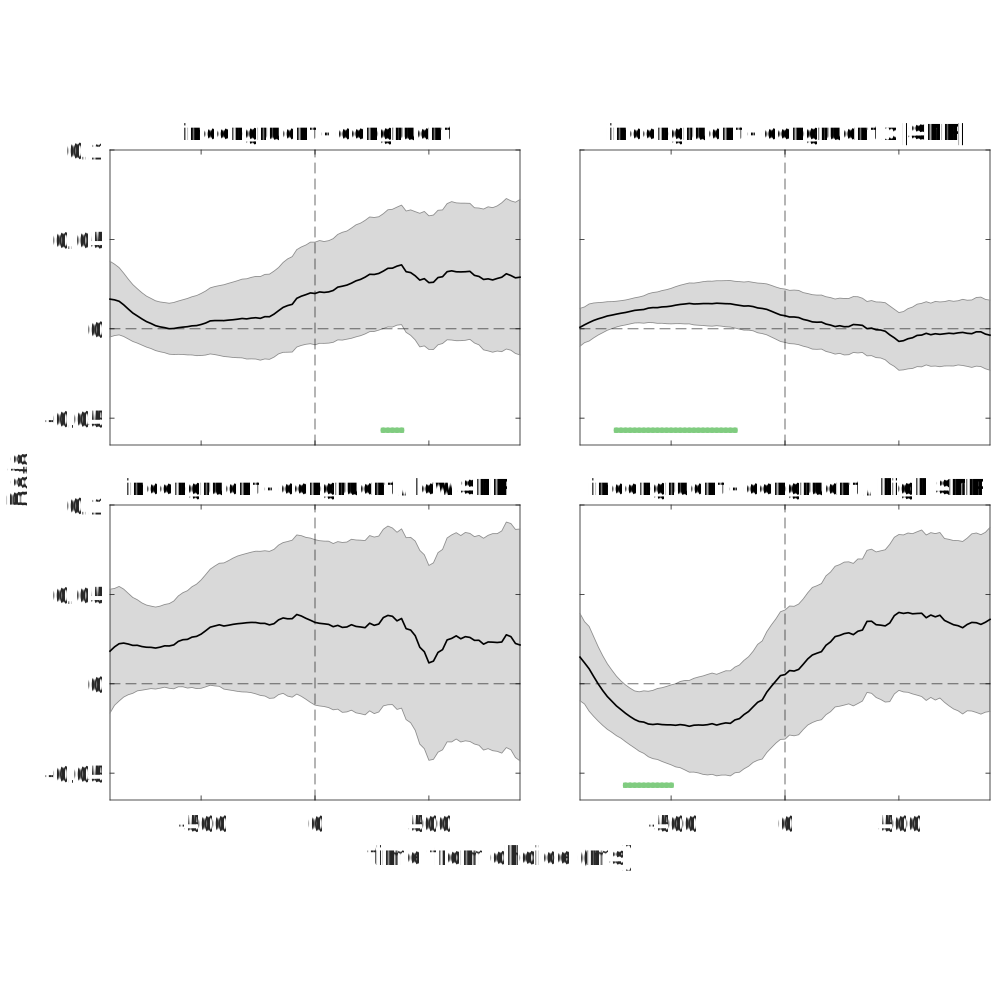

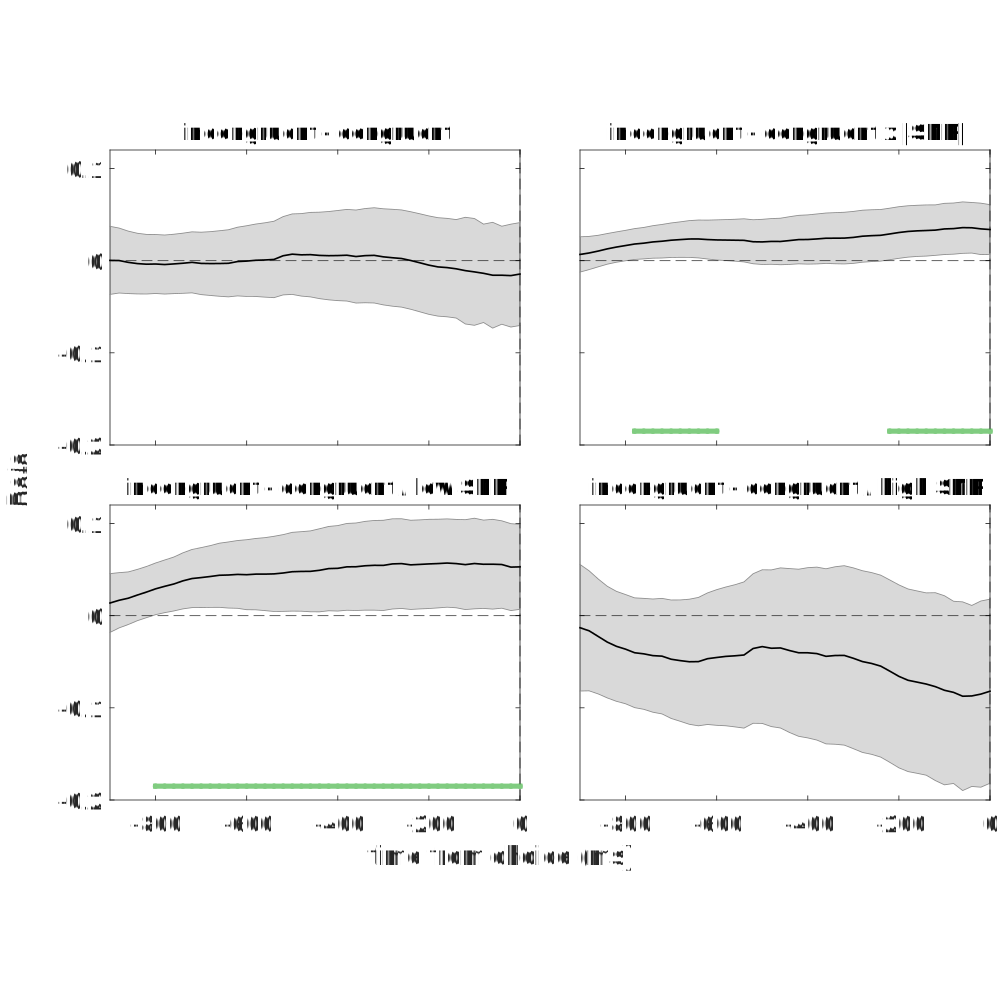

In [11]:
%Fig 6b

set(groot,'DefaultAxesFontSize',15)
this_subplotv = @(m,n,p) subtightplot(m,n,p,.06,[.2 .15],[0.11 0.01]);

p_type = 1;
p_list = {'p','p_corr'};
p_colors = {[0.5 0.8 0.5],'green'};
p_var = p_list{p_type}

%plot_params = {{'incon - con','congruent.f1:aSNR.f1',...
%                'incon high SNR - con high SNR','incon low SNR - con low SNR'}};
plot_params = {{'incon - con','congruent.f1:aSNR.f1',...
                'incon low SNR - con low SNR','incon high SNR - con high SNR'}};
ylim_min = [-.065 -.2]; %[-.275,-.63];
ylim_max = [.1 .12];
success_title = {'correct','incorrect'};
%param_titles = {'incongruent - congruent','incongruent - congruent x |SNR|',...
%    'incongruent - congruent / high SNR','incongruent - congruent / low SNR'};
param_titles = {'incongruent - congruent','incongruent - congruent x |SNR|',...
    'incongruent - congruent / low SNR','incongruent - congruent / high SNR'};
for s=1:length(choice_lm_success)
    for pp=1:length(plot_params)
        this_plot_params = plot_params{pp};
        figure('Position',[100 100 800 800]);
        for i=1:length(this_plot_params)
            this_subplotv(2,2,i)
            this_param = this_plot_params{i};
            this_choice_lm = choice_lm(strcmp(choice_lm.param,this_param) & choice_lm.success==choice_lm_success(s),:);
            h_choice_lm=shadedErrorBar(this_choice_lm.time, ...
                this_choice_lm.B, ...
                this_choice_lm.CI_halfwidth, ...
                '-k',1);
            %xlabel('time from choice (ms)')
            title(['\fontsize{14}' param_titles{i}])
            h_choice_lm.mainLine.LineWidth = 1;
            hold on;

            %add significance line
            choice_sig = double(this_choice_lm.(p_var) < 0.05);
            choice_sig(choice_sig == 0) = NaN;
            choice_sig_y = ylim_min(s) + (.1 - ylim_min(s))*.05;%min(choice_lm.CI_lower(strcmp(choice_lm.param,this_param))) - .05;
            h_choice_sig = plot(this_choice_lm.time,...
                choice_sig .* choice_sig_y,'.-','LineWidth',3.1, 'Color', p_colors{p_type},...
                'MarkerSize',10);
            yline(0,'--k');
            xline(0,'--k');
            ylim([ylim_min(s) ylim_max(s)]);
            xlim([min(choice_lm.time(choice_lm.success==choice_lm_success(s))) ...
                max(choice_lm.time(choice_lm.success==choice_lm_success(s)))]);
                
            if i <= 2
                set(gca,'Xticklabel',[]) 
            end
            if mod(i,2)==0
                set(gca,'Yticklabel',[]) 
            end

            clear this_choice_lm
        end
            suplabel('time from choice (ms)','x',[.08 .2 .84 .84]);
            suplabel('\it{Beta}','y',[.08 0.1 .84 .84]);
    end
    set(gcf,'Renderer','painters')
end

set(gcf,'Renderer','painters')
set(groot,'DefaultAxesFontSize','factory')

## stim-aligned

### Does pupil show an effect of congruence x SNR?
Just plotting for most extreme congruence/SNR conditions...

In [12]:
data_ave_stim_SNR_congruent2_subj = varfun(@nanmean,...
    data(data.trial_time_stimOnT >= -275 & ...
    data.trial_time_stimOnT <=1360,:),'InputVariables','pupilCblz2',...
    'GroupingVariables',{'dataID','success','aSNR','congruent','trial_time_stimOnT'});
data_ave_stim_SNR_congruent2 = summary_stats(data_ave_stim_SNR_congruent2_subj,'nanmean_pupilCblz2',...
    {'success','aSNR','congruent','trial_time_stimOnT'},1);

congruent=3 | SNR=0.50
congruent=0 | SNR=0.50
congruent=3 | SNR=0.05
congruent=0 | SNR=0.05
congruent=3 | SNR=0.50
congruent=0 | SNR=0.50
congruent=3 | SNR=0.05
congruent=0 | SNR=0.05


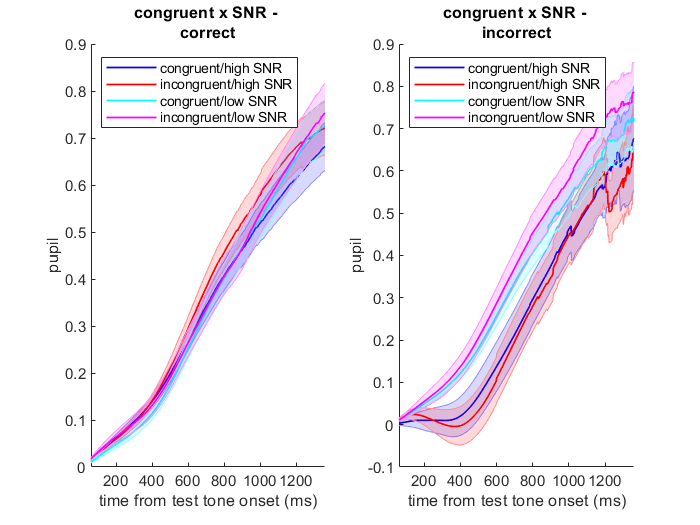

In [13]:
line_specs = {'b','r';'c','m'};
aSNRs = [.5,.05];
conds = [3,0];
cond_labels = {'congruent/high SNR','incongruent/high SNR','congruent/low SNR','incongruent/low SNR'};
success = [1,0];
success_title = {'correct','incorrect'};
%figure();hold on;
for c=1:length(success)
    subplot(1,2,c);hold on
    hC = [];
    for s=1:length(aSNRs)
        for j=1:length(conds)
            fprintf('congruent=%d | SNR=%.2f\n',conds(j),aSNRs(s));
            this_data_con_SNR = data_ave_stim_SNR_congruent2(...
                data_ave_stim_SNR_congruent2.congruent == conds(j) & ...
                data_ave_stim_SNR_congruent2.aSNR == aSNRs(s) & ...
                data_ave_stim_SNR_congruent2.success==success(c),:);
            h=shadedErrorBar(this_data_con_SNR.trial_time_stimOnT, ...
                this_data_con_SNR.nanmean_nanmean_pupilCblz2, ...
                this_data_con_SNR.nansem_nanmean_pupilCblz2, ...
                line_specs{s,j},1);
            hC = [hC h.mainLine];
        end
    end
    [hC.LineWidth] = deal(1); 
    %title(['Stim congruent x SNR - ' success_title(c)])
    title(['congruent x SNR - ' success_title(c)])
    xlabel('time from test tone onset (ms)')
    ylabel('pupil')
    %xlim([-ptdurs(1)-100 300])
    %xlim([-400 1000])
    xlim([60 1360])
    %for x=[-ptdurs(1):400:0]
    %    xline(x,'--r','LineWidth',2);
    %end
    legend(hC,cond_labels, 'Location', 'northwest')
end

#### stim-aligned regressions


p_var =

    'p_corr'

Set 'VariableNamingRule' to 'preserve' to use the original column headers as table variable names.
Set 'VariableNamingRule' to 'preserve' to use the original column headers as table variable names.


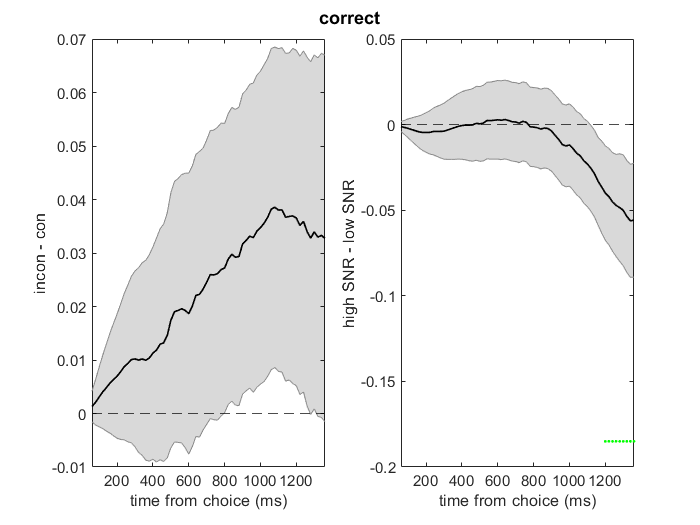

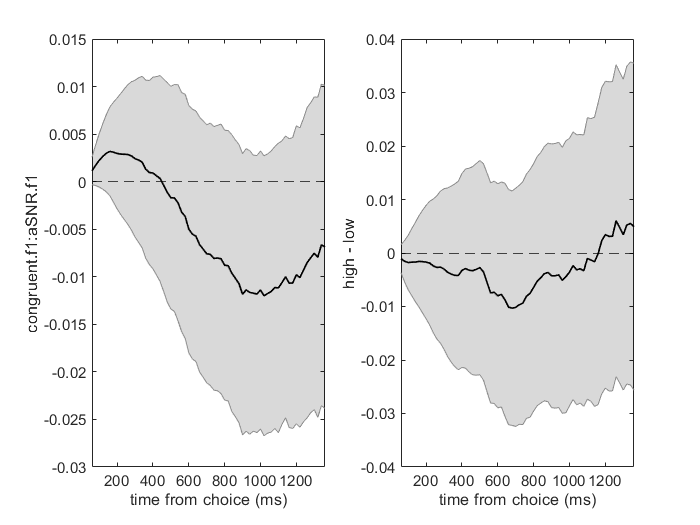

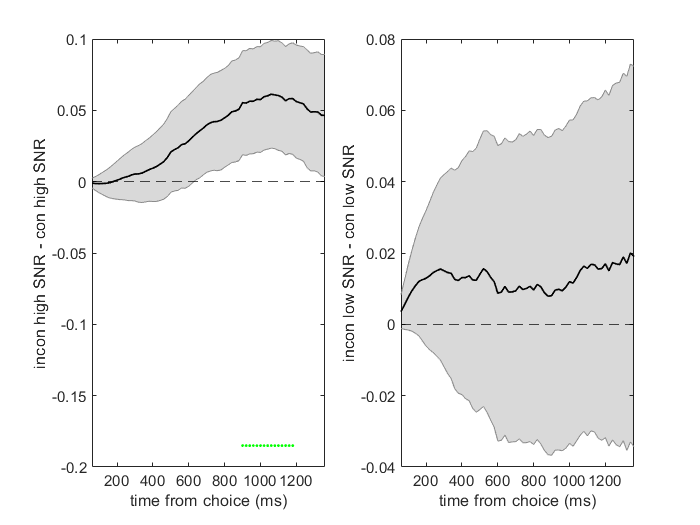

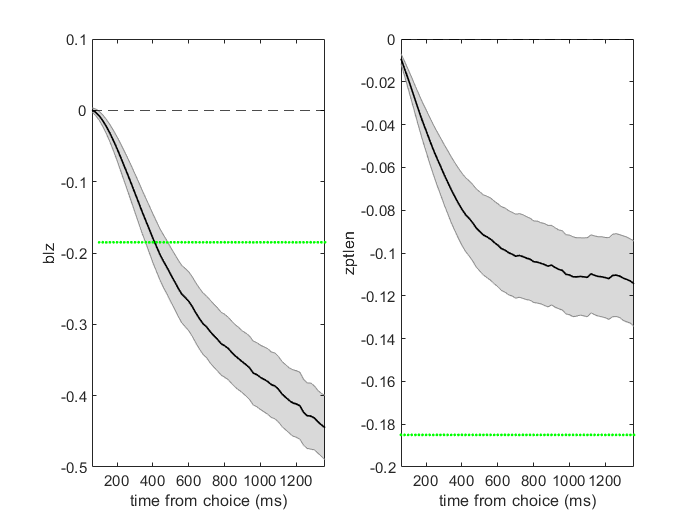

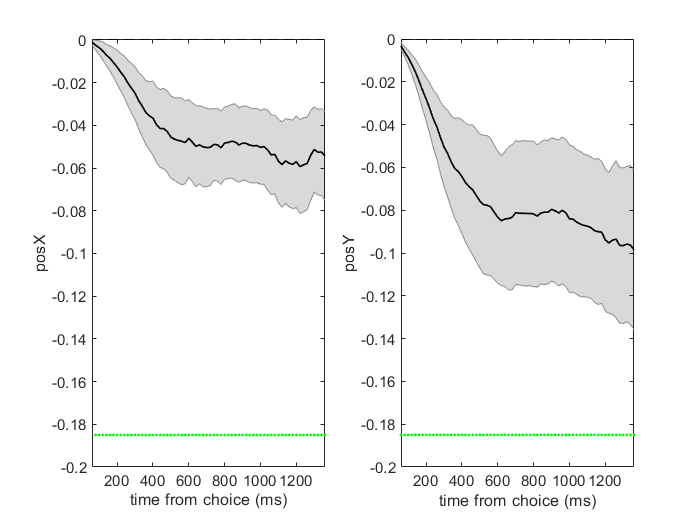

In [14]:
p_type = 2;
p_list = {'p','p_corr'};
p_colors = {[0.5 0.8 0.5],'green'};
p_var = p_list{p_type}

STIM_LM_FILE = {'stim_ptO_lm_cs_final_2021-06-09.csv',...
    ''};
STIM_EMM_FILE = {'stim_ptO_emm_cs_final_2021-06-09.csv',...
    ''};

stim_lm = [];
stim_emm = [];
stim_lm_success = [1];
for i=1:length(stim_lm_success)
    this_stim_lm = readtable(STIM_LM_FILE{i});
    this_stim_lm.success = repmat(stim_lm_success(i),...
        height(this_stim_lm),1);
    stim_lm = [stim_lm; this_stim_lm];
    
    this_stim_emm = readtable(STIM_EMM_FILE{i});
    this_stim_emm.success = repmat(stim_lm_success(i),...
        height(this_stim_emm),1);
    stim_emm = [stim_emm; this_stim_emm];
    
    clear this_stim_lm this_stim_emm
end
stim_lm = [stim_lm;stim_emm];
clear stim_emm;

stim_lm = sortrows(stim_lm,{'success','time','param'}); % {'time','param'});
stim_lm.CI_halfwidth = stim_lm.B - stim_lm.CI_lower;

%now FDR correct! [NOT IMPLEMENTED IN R as of now]
group_correct = {'incon high SNR - con high SNR','incon low SNR - con low SNR'};
stim_lm = lm_adjust(stim_lm,group_correct);

plot_params = {{'incon - con', 'high SNR - low SNR'},... 
                {'congruent.f1:aSNR.f1','high - low'},...
                {'incon high SNR - con high SNR','incon low SNR - con low SNR'},...
                {'blz','zptlen'},{'posX','posY'}};
ylim_min = -.2; %[-.275,-.63];
success_title = {'correct','incorrect'};
for s=1:length(stim_lm_success)
    for pp=1:length(plot_params)
        this_plot_params = plot_params{pp};
        figure();
        for i=1:length(this_plot_params)
            subplot(1,2,i)
            this_param = this_plot_params{i};
            this_stim_lm = stim_lm(strcmp(stim_lm.param,this_param) & stim_lm.success==stim_lm_success(s),:);
            h_stim_lm=shadedErrorBar(this_stim_lm.time, ...
                this_stim_lm.B, ...
                this_stim_lm.CI_halfwidth, ...
                '-k',1);
            xlabel('time from choice (ms)')
            ylabel(this_param)
            h_stim_lm.mainLine.LineWidth = 1;
            hold on;

            %add significance line
            stim_sig = double(this_stim_lm.(p_var) < 0.05);
            stim_sig(stim_sig == 0) = NaN;
            stim_sig_y = ylim_min + (.1 - ylim_min)*.05;%min(stim_lm.CI_lower(strcmp(stim_lm.param,this_param))) - .05;
            h_stim_sig = plot(this_stim_lm.time,...
                stim_sig .* stim_sig_y,'.','LineWidth',1, 'Color', p_colors{p_type},'MarkerSize',5);
            yline(0,'--k');
            xline(0,'--k');
            %ylim([ylim_min(pp) 1]);
            xlim([min(stim_lm.time(stim_lm.success==stim_lm_success(s))) ...
                max(stim_lm.time(stim_lm.success==stim_lm_success(s)))]);

            clear this_stim_lm
        end
        %suplabel(sprintf('success=%d',stim_lm_success(s)),'t',...
        %    [.08 .1 .84 .84]);
        if pp==1
            suplabel(success_title{s},'t',...
                [.08 .1 .84 .84]);
        end
    end
end

In [15]:
min(stim_lm.p(strcmp(stim_lm.param,'congruent.f1:aSNR.f1') & stim_lm.success==1))
min(stim_lm.p_corr(strcmp(stim_lm.param,'congruent.f1:aSNR.f1') & stim_lm.success==1))


ans =

    0.1139


ans =

    0.5333

